In [4]:
# This file reads in a csv of hourly normals taken from https://www.ncei.noaa.gov/cdo-web/search from Seatac airport for 2010.
# Then preprocesses data before feed hourly temperature normals, and hourly wind direction it to a multivariable LSTM model
# to train and use to forecast the temperature.

from keras.callbacks import ModelCheckpoint
from keras.layers import *
from keras.models import load_model
from keras.losses import MeanSquaredError
from keras.models import Sequential
from keras.metrics import RootMeanSquaredError
from keras.optimizers import Adam

import math
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib

2024-02-10 14:44:58.827314: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-10 14:44:58.849187: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-10 14:44:58.849205: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-10 14:44:58.849956: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-10 14:44:58.853936: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-10 14:44:58.854521: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [3]:
# Load data

weather = pd.read_csv("3588306.csv", index_col="DATE")

In [ ]:
weather

In [4]:
# Remove unused data points

del weather["HLY-PRES-NORMAL"]
del weather["STATION"]
del weather["NAME"]

In [5]:
weather

,HLY-TEMP-NORMAL,HLY-WIND-1STDIR
DATE,,
01-01T01:00:00,39.2,5
01-01T02:00:00,39.0,5
01-01T03:00:00,38.9,5
01-01T04:00:00,38.8,5
01-01T05:00:00,38.7,5
...,...,...
12-31T19:00:00,40.7,5
12-31T20:00:00,40.5,5
12-31T21:00:00,40.2,5


In [6]:
# Check for NAN vals

weather.apply(pd.isnull).sum()

HLY-TEMP-NORMAL    0
HLY-WIND-1STDIR    0
dtype: int64

<Axes: xlabel='DATE'>

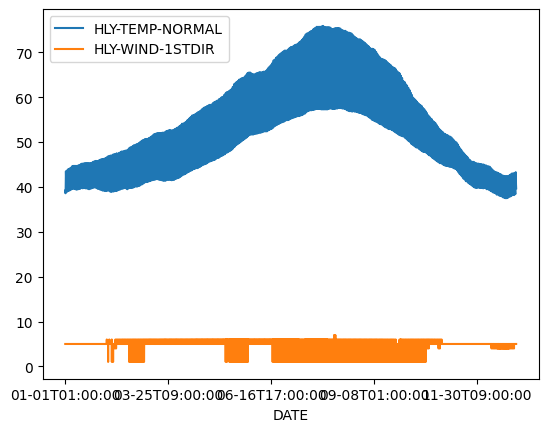

In [8]:
# Take a look at data using

weather[["HLY-TEMP-NORMAL"]].plot()

In [9]:
# Function to create sliding window of past data points to feed model

def df_to_X_y(df, window_size=10):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [r for r in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size][0]
    y.append(label)
  return np.array(X), np.array(y)

In [10]:
# Generate data 

WINDOW_SIZE = 10
X, y = df_to_X_y(weather["HLY-TEMP-NORMAL"])
X.shape, y.shape

((8749, 10, 1), (8749,))

In [11]:
# Break up data into training, validation, and test sets

X_train, y_train = X[:7700], y[:7700]
X_val, y_val = X[7700:8200], y[7700:8200]
X_test, y_test = X1[8200:], y[8200:]
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((7700, 10, 1), (7700,), (500, 10, 1), (500,), (549, 10, 1), (549,))

In [6]:
# Define LSTM model using using window size 10 for 1 variable input

model = Sequential()
model.add(InputLayer((10, 1)))
model.add(LSTM(64))
model.add(Dense(8, 'relu'))
model.add(Dense(1, 'linear'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 64)                16896     
                                                                 
 dense_2 (Dense)             (None, 8)                 520       
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17425 (68.07 KB)
Trainable params: 17425 (68.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [7]:
# Create model checkpoint to save best model, then finally compile model

cp = ModelCheckpoint('model/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [16]:
# Train model

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, callbacks=[cp])

Epoch 1/50
214/241 [=========================>....] - ETA: 0s - loss: 2824.9878 - root_mean_squared_error: 53.1506INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


241/241 [==============================] - 3s 10ms/step - loss: 2810.0742 - root_mean_squared_error: 53.0101 - val_loss: 1556.9275 - val_root_mean_squared_error: 39.4579
Epoch 2/50
223/241 [==========================>...] - ETA: 0s - loss: 2376.6843 - root_mean_squared_error: 48.7513INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


241/241 [==============================] - 2s 8ms/step - loss: 2356.1235 - root_mean_squared_error: 48.5399 - val_loss: 1106.0221 - val_root_mean_squared_error: 33.2569
Epoch 3/50
227/241 [===========================>..] - ETA: 0s - loss: 1839.0526 - root_mean_squared_error: 42.8842INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


241/241 [==============================] - 2s 9ms/step - loss: 1827.2583 - root_mean_squared_error: 42.7464 - val_loss: 779.0593 - val_root_mean_squared_error: 27.9116
Epoch 4/50
221/241 [==========================>...] - ETA: 0s - loss: 1436.7490 - root_mean_squared_error: 37.9045INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


241/241 [==============================] - 2s 8ms/step - loss: 1425.5321 - root_mean_squared_error: 37.7562 - val_loss: 555.1877 - val_root_mean_squared_error: 23.5624
Epoch 5/50
220/241 [==========================>...] - ETA: 0s - loss: 1161.4320 - root_mean_squared_error: 34.0798INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


241/241 [==============================] - 2s 8ms/step - loss: 1152.6827 - root_mean_squared_error: 33.9512 - val_loss: 392.5217 - val_root_mean_squared_error: 19.8122
Epoch 6/50
220/241 [==========================>...] - ETA: 0s - loss: 930.8937 - root_mean_squared_error: 30.5106INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


241/241 [==============================] - 2s 9ms/step - loss: 922.4872 - root_mean_squared_error: 30.3725 - val_loss: 259.7140 - val_root_mean_squared_error: 16.1156
Epoch 7/50
224/241 [==========================>...] - ETA: 0s - loss: 729.4510 - root_mean_squared_error: 27.0084INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


241/241 [==============================] - 2s 8ms/step - loss: 722.8397 - root_mean_squared_error: 26.8857 - val_loss: 156.0223 - val_root_mean_squared_error: 12.4909
Epoch 8/50
239/241 [============================>.] - ETA: 0s - loss: 554.4838 - root_mean_squared_error: 23.5475INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


241/241 [==============================] - 2s 8ms/step - loss: 553.5387 - root_mean_squared_error: 23.5274 - val_loss: 80.6566 - val_root_mean_squared_error: 8.9809
Epoch 9/50
217/241 [==========================>...] - ETA: 0s - loss: 420.6976 - root_mean_squared_error: 20.5109INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


241/241 [==============================] - 2s 9ms/step - loss: 414.8148 - root_mean_squared_error: 20.3670 - val_loss: 32.4565 - val_root_mean_squared_error: 5.6971
Epoch 10/50
219/241 [==========================>...] - ETA: 0s - loss: 308.2811 - root_mean_squared_error: 17.5579INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


241/241 [==============================] - 2s 8ms/step - loss: 305.8038 - root_mean_squared_error: 17.4872 - val_loss: 8.4077 - val_root_mean_squared_error: 2.8996
Epoch 11/50
219/241 [==========================>...] - ETA: 0s - loss: 229.1797 - root_mean_squared_error: 15.1387INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


241/241 [==============================] - 2s 9ms/step - loss: 224.4908 - root_mean_squared_error: 14.9830 - val_loss: 4.3020 - val_root_mean_squared_error: 2.0741
Epoch 12/50
241/241 [==============================] - 0s 2ms/step - loss: 167.5068 - root_mean_squared_error: 12.9424 - val_loss: 14.8275 - val_root_mean_squared_error: 3.8507
Epoch 13/50
241/241 [==============================] - 0s 2ms/step - loss: 130.3906 - root_mean_squared_error: 11.4189 - val_loss: 34.0726 - val_root_mean_squared_error: 5.8372
Epoch 14/50
241/241 [==============================] - 0s 2ms/step - loss: 108.1706 - root_mean_squared_error: 10.4005 - val_loss: 56.5840 - val_root_mean_squared_error: 7.5222
Epoch 15/50
241/241 [==============================] - 0s 2ms/step - loss: 96.1347 - root_mean_squared_error: 9.8048 - val_loss: 78.0469 - val_root_mean_squared_error: 8.8344
Epoch 16/50
241/241 [==============================] - 0s 2ms/step - loss: 90.3566 - root_mean_squared_error: 9.5056 - val_loss: 9

INFO:tensorflow:Assets written to: model1/assets


241/241 [==============================] - 2s 8ms/step - loss: 21.6295 - root_mean_squared_error: 4.6508 - val_loss: 4.0339 - val_root_mean_squared_error: 2.0084
Epoch 23/50
216/241 [=========================>....] - ETA: 0s - loss: 15.8658 - root_mean_squared_error: 3.9832INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


241/241 [==============================] - 2s 8ms/step - loss: 15.4054 - root_mean_squared_error: 3.9250 - val_loss: 1.8661 - val_root_mean_squared_error: 1.3660
Epoch 24/50
223/241 [==========================>...] - ETA: 0s - loss: 11.7057 - root_mean_squared_error: 3.4214INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


241/241 [==============================] - 2s 9ms/step - loss: 11.4854 - root_mean_squared_error: 3.3890 - val_loss: 1.1310 - val_root_mean_squared_error: 1.0635
Epoch 25/50
222/241 [==========================>...] - ETA: 0s - loss: 8.9760 - root_mean_squared_error: 2.9960INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


241/241 [==============================] - 2s 8ms/step - loss: 8.8932 - root_mean_squared_error: 2.9822 - val_loss: 0.8422 - val_root_mean_squared_error: 0.9177
Epoch 26/50
216/241 [=========================>....] - ETA: 0s - loss: 7.1968 - root_mean_squared_error: 2.6827INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


241/241 [==============================] - 2s 8ms/step - loss: 7.0458 - root_mean_squared_error: 2.6544 - val_loss: 0.6805 - val_root_mean_squared_error: 0.8249
Epoch 27/50
223/241 [==========================>...] - ETA: 0s - loss: 5.7208 - root_mean_squared_error: 2.3918INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


241/241 [==============================] - 2s 9ms/step - loss: 5.6502 - root_mean_squared_error: 2.3770 - val_loss: 0.5355 - val_root_mean_squared_error: 0.7318
Epoch 28/50
222/241 [==========================>...] - ETA: 0s - loss: 4.5419 - root_mean_squared_error: 2.1312INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


241/241 [==============================] - 2s 8ms/step - loss: 4.5305 - root_mean_squared_error: 2.1285 - val_loss: 0.4237 - val_root_mean_squared_error: 0.6509
Epoch 29/50
241/241 [==============================] - 0s 2ms/step - loss: 3.6721 - root_mean_squared_error: 1.9163 - val_loss: 0.4419 - val_root_mean_squared_error: 0.6647
Epoch 30/50
220/241 [==========================>...] - ETA: 0s - loss: 3.0409 - root_mean_squared_error: 1.7438INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


241/241 [==============================] - 2s 9ms/step - loss: 3.0157 - root_mean_squared_error: 1.7366 - val_loss: 0.3608 - val_root_mean_squared_error: 0.6006
Epoch 31/50
241/241 [==============================] - 0s 2ms/step - loss: 2.4966 - root_mean_squared_error: 1.5801 - val_loss: 0.3786 - val_root_mean_squared_error: 0.6153
Epoch 32/50
241/241 [==============================] - 0s 2ms/step - loss: 2.0971 - root_mean_squared_error: 1.4482 - val_loss: 0.3927 - val_root_mean_squared_error: 0.6267
Epoch 33/50
240/241 [============================>.] - ETA: 0s - loss: 1.7922 - root_mean_squared_error: 1.3387INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


241/241 [==============================] - 2s 8ms/step - loss: 1.7935 - root_mean_squared_error: 1.3392 - val_loss: 0.3255 - val_root_mean_squared_error: 0.5705
Epoch 34/50
220/241 [==========================>...] - ETA: 0s - loss: 1.5617 - root_mean_squared_error: 1.2497INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


241/241 [==============================] - 2s 8ms/step - loss: 1.5599 - root_mean_squared_error: 1.2490 - val_loss: 0.3078 - val_root_mean_squared_error: 0.5548
Epoch 35/50
241/241 [==============================] - 0s 2ms/step - loss: 1.3742 - root_mean_squared_error: 1.1723 - val_loss: 0.3410 - val_root_mean_squared_error: 0.5839
Epoch 36/50
241/241 [==============================] - 0s 2ms/step - loss: 1.2306 - root_mean_squared_error: 1.1093 - val_loss: 0.3264 - val_root_mean_squared_error: 0.5713
Epoch 37/50
221/241 [==========================>...] - ETA: 0s - loss: 1.0966 - root_mean_squared_error: 1.0472INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


241/241 [==============================] - 2s 9ms/step - loss: 1.1006 - root_mean_squared_error: 1.0491 - val_loss: 0.2891 - val_root_mean_squared_error: 0.5376
Epoch 38/50
241/241 [==============================] - 0s 2ms/step - loss: 1.0035 - root_mean_squared_error: 1.0018 - val_loss: 0.3153 - val_root_mean_squared_error: 0.5615
Epoch 39/50
222/241 [==========================>...] - ETA: 0s - loss: 0.9274 - root_mean_squared_error: 0.9630INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


241/241 [==============================] - 2s 8ms/step - loss: 0.9154 - root_mean_squared_error: 0.9568 - val_loss: 0.2658 - val_root_mean_squared_error: 0.5155
Epoch 40/50
220/241 [==========================>...] - ETA: 0s - loss: 0.8308 - root_mean_squared_error: 0.9115INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


241/241 [==============================] - 2s 8ms/step - loss: 0.8317 - root_mean_squared_error: 0.9120 - val_loss: 0.2394 - val_root_mean_squared_error: 0.4893
Epoch 41/50
222/241 [==========================>...] - ETA: 0s - loss: 0.7607 - root_mean_squared_error: 0.8722INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


241/241 [==============================] - 2s 9ms/step - loss: 0.7664 - root_mean_squared_error: 0.8755 - val_loss: 0.2122 - val_root_mean_squared_error: 0.4606
Epoch 42/50
241/241 [==============================] - 0s 2ms/step - loss: 0.7082 - root_mean_squared_error: 0.8415 - val_loss: 0.2178 - val_root_mean_squared_error: 0.4667
Epoch 43/50
241/241 [==============================] - 0s 2ms/step - loss: 0.6582 - root_mean_squared_error: 0.8113 - val_loss: 0.2176 - val_root_mean_squared_error: 0.4665
Epoch 44/50
216/241 [=========================>....] - ETA: 0s - loss: 0.6104 - root_mean_squared_error: 0.7812INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


241/241 [==============================] - 2s 8ms/step - loss: 0.6141 - root_mean_squared_error: 0.7837 - val_loss: 0.1872 - val_root_mean_squared_error: 0.4326
Epoch 45/50
241/241 [==============================] - 1s 2ms/step - loss: 0.5732 - root_mean_squared_error: 0.7571 - val_loss: 0.2059 - val_root_mean_squared_error: 0.4537
Epoch 46/50
217/241 [==========================>...] - ETA: 0s - loss: 0.5403 - root_mean_squared_error: 0.7351INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


241/241 [==============================] - 2s 9ms/step - loss: 0.5425 - root_mean_squared_error: 0.7366 - val_loss: 0.1725 - val_root_mean_squared_error: 0.4153
Epoch 47/50
241/241 [==============================] - ETA: 0s - loss: 0.5141 - root_mean_squared_error: 0.7170INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


241/241 [==============================] - 2s 8ms/step - loss: 0.5141 - root_mean_squared_error: 0.7170 - val_loss: 0.1659 - val_root_mean_squared_error: 0.4073
Epoch 48/50
241/241 [==============================] - 0s 2ms/step - loss: 0.4944 - root_mean_squared_error: 0.7032 - val_loss: 0.1719 - val_root_mean_squared_error: 0.4146
Epoch 49/50
241/241 [==============================] - 0s 2ms/step - loss: 0.4690 - root_mean_squared_error: 0.6848 - val_loss: 0.1745 - val_root_mean_squared_error: 0.4178
Epoch 50/50
241/241 [==============================] - 0s 2ms/step - loss: 0.4497 - root_mean_squared_error: 0.6706 - val_loss: 0.1696 - val_root_mean_squared_error: 0.4118


In [17]:
# Load best model

model = load_model('model/')

In [18]:
# Compare model predictions vs actual values

train_predictions = model.predict(X_train).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train1})
train_results

241/241 [==============================] - 0s 833us/step


,Train Predictions,Actuals
0,40.533623,41.3
1,41.893574,42.5
2,43.219318,43.2
3,43.841194,43.5
4,43.742672,43.3
...,...,...
7695,43.487942,43.1
7696,42.905926,42.9
7697,42.670689,42.6
7698,42.530212,42.5


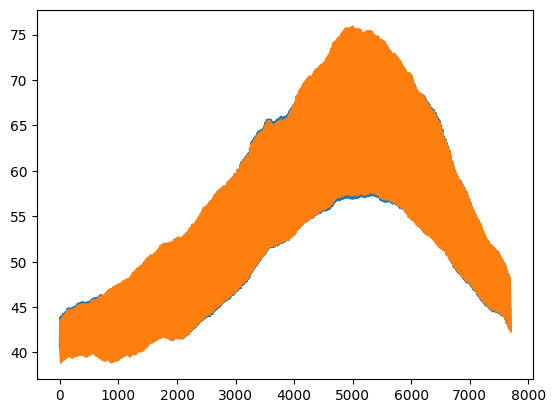

In [19]:
# Plot results for visual representation

plt.plot(train_results['Train Predictions'][:])
plt.plot(train_results['Actuals'][:])

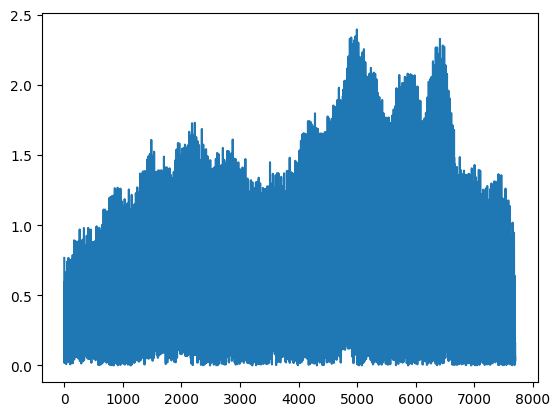

In [21]:
# Plotting deviation from actual temperatures

margin = abs(train_results['Actuals'][:] - train_results['Train Predictions'][:])
plt.plot(margin)

In [31]:
# Define function for plotting windows of time for predictions vs actuals

from sklearn.metrics import mean_squared_error as mse

def plot_predictions1(model, X, y, start=0, end=100):
  predictions = model.predict(X).flatten()
  df = pd.DataFrame(data={'Predictions': predictions, 'Actuals':y})
  plt.plot(df['Predictions'][start:end])
  plt.plot(df['Actuals'][start:end])
  return df, mse(predictions, y)

18/18 [==============================] - 0s 983us/step


(     Predictions  Actuals
 0      40.189869     40.0
 1      40.045330     39.8
 2      39.984615     39.6
 3      39.811977     39.5
 4      39.703453     39.6
 ..           ...      ...
 544    40.539612     40.7
 545    40.549458     40.5
 546    40.612793     40.2
 547    40.395428     40.0
 548    40.153191     39.7
 
 [549 rows x 2 columns],
 0.20845916564339673)

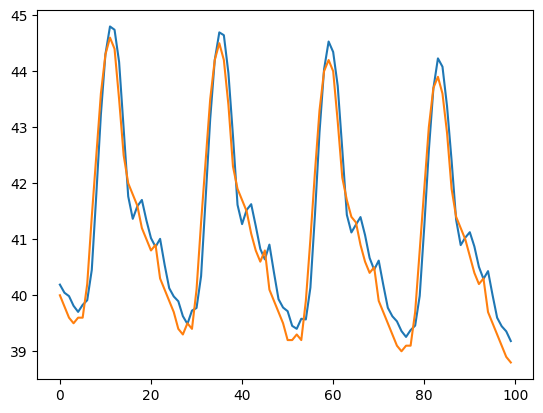

In [33]:
# Plotting window of 100 hours to have finer detail

plot_predictions1(model1, X_test1, y_test1)